# TFM - Obtención de varias CNNs
## Ismael Franco Hernando
#### Imports

In [2]:
from tensorflow import keras
from mysql.connector import (connection)
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential;
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE
import matplotlib.pyplot as plt
import os

#### Se realiza una conexión con la base de datos y se cargan las features de cada bobina

In [3]:
try:
    cnx = connection.MySQLConnection(user='leer', 
                                     password='candanal',
                                     host='138.100.82.178',
                                     database='deepquality_tmp')

except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Usuario o contraseña incorrecto")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("La base de datos no existe")
    else:
        print(err)

In [4]:
# Guardamos y mostramos las bobinas 
q01 = "SELECT * FROM FEATURES_1D"
fea1D = pd.read_sql(q01,cnx)
fea1D

,COILID,MID,ZNMAX_FAILURES,ZNMIN_FAILURES,CALIBRATED,TOTAL_TILEID,L_DIS,R_DIS,MAP,DECISSION_OP
0,225216688,123.0,0,6,0,26,13,12,"[-1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1...",OK
1,225216688,124.0,4,0,0,26,3,6,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OK
2,225216688,201.0,1,1,0,26,3,4,"[-1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OK
3,225216688,202.0,1,1,0,26,13,13,"[1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...",OK
4,225220725,123.0,2,5,0,54,17,27,"[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, -1, 0, -1, 0, -...",OK
...,...,...,...,...,...,...,...,...,...,...
4635,233652453,202.0,2,0,0,16,8,8,"[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]",OK
4636,233667056,123.0,1,0,0,26,13,13,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",OK
4637,233667056,124.0,1,1,0,26,13,13,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",OK
4638,233667056,201.0,1,0,0,26,13,13,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",OK


In [5]:
# Se cierra la conexión con la base de datos
cnx.close()

#### Union de los mapas
Para cada bobina se unen los mapas de la capa de arriba, sensores 123 y 124, y los mapas de las capas de abajo, sensores 201 y 202.

In [6]:
def unionMapas(datos):
    bobinas = datos['COILID'].unique()
    sensores = [(123.0, 124.0), (201.0, 202.0)]
    X = np.zeros(2320).tolist()
    Y = []
    contadorID = 0
    
    for bob in bobinas:
        for s in sensores:
            mapa1 = datos.loc[datos['COILID']==bob].loc[datos['MID']==s[0]].MAP.iloc[0]      
            mapa1 = np.array(mapa1[1:-1].split(',')).astype(int)
            mapa2 = datos.loc[datos['COILID']==bob].loc[datos['MID']==s[1]].MAP.iloc[0]      
            mapa2 = np.array(mapa2[1:-1].split(',')).astype(int)
            X[contadorID] = np.concatenate((mapa1, mapa2), axis=0)
            Y.append(datos.loc[datos['COILID']==bob].DECISSION_OP.iloc[0])
            contadorID+=1
            
    return X,Y      


In [7]:
X,Y = unionMapas(fea1D)

#### Separación de una muestra de los datos originales

In [8]:
# Listas que contendrán los valores X, Y de la muestra con etiquetas OK y NOK
muestraXOK = []
muestraYOK = []
muestraXNOK = []
muestraYNOK = []
# Tamaño de cada muestra que se quiere separar
tam_muestraOK = 50
tam_muestraNOK = 150

# Se recorren los valores de manera inversa, para no tener problema con las posiciones
for i in reversed(range(len(Y))):
    # Label de la posición i
    label = Y[i]
    
    # Comprobamos si la label es OK y si no se han añadido suficientes valores a la muestra
    if (label == 'OK') and (len(muestraYOK)<tam_muestraOK):
        # Se añaden los valores X e Y a la muestra
        muestraYOK.append(label)
        muestraXOK.append(X[i])
        # Se eliminan de los datos originales
        X.pop(i)
        Y.pop(i)
        
    # Comprobamos si la label es NOK y si no se han añadido suficientes valores a la muestra
    elif (label == 'NOK') and (len(muestraYNOK)<tam_muestraNOK):
        # Se añaden los valores X e Y a la muestra
        muestraYNOK.append(label)
        muestraXNOK.append(X[i])
        # Se eliminan de los datos originales
        X.pop(i)
        Y.pop(i)
    
    # Se comprueba si ya se cuenta con suficientes datos y se hace un break del for
    elif (len(muestraYNOK) == tam_muestraNOK) and (len(muestraYOK) == tam_muestraOK):
        break
    

In [9]:
# Se unen las muestras de OK y NOK
muestraX = muestraXOK + muestraXNOK
muestraY = muestraYOK + muestraYNOK

#### Procesado de los datos para usarlos en la CNN
En primer lugar se obtiene el mapa de mayor tamaño de entre todas las bobinas para hacer un padding y que todas las bobinas cuenten con el mismo tamaño.

In [10]:
longitudes = []
for x in X:
    longitudes.append(len(x))
    
maxLongitud = max(longitudes)

In [11]:
nuevoX = []
for x in X:
    nuevoX.append(np.pad(x, (0,maxLongitud-len(x)), 'constant', constant_values= 0))
    

A continuación, se expande la dimensión del array de 2D a 3D ya que la CNN de tensroflow necesita que los datos de entrada estén en 3D

In [12]:
X = np.expand_dims(nuevoX, axis=-1)
X.shape

(2120, 208, 1)

La CNN necesita que las clases estén en valor numérico, por lo que se pasa la label OK a 0 y NOK a 1

In [13]:
nuevoY = []
for y in Y:
    if y == 'OK':
        nuevoY.append(0)
    else:
        nuevoY.append(1) 
        
Y = nuevoY

#### División de los datos para entrenar y para test

In [14]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=18)

### Creación y evaluación del modelo con datos originales

In [15]:
# Se crea el modelo y se muestra su configuración
modelo = Sequential();
modelo.add(Conv1D(32, 3, activation='relu', input_shape=(maxLongitud, 1)))
modelo.add(MaxPooling1D(2))
modelo.add(Flatten())
modelo.add(Dense(32, activation='relu'))
modelo.add(Dense(8, activation='relu'))
modelo.add(Dense(1, activation='relu'))

modelo.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 206, 32)           128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 103, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3296)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                105504    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Tota

In [16]:
# Se compila el modelo
modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
os.makedirs('tmp/checkpoint', exist_ok=True)
filepath="tmp/checkpoint/best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
# Se entrena el modelo
proceso = modelo.fit(Xtrain, Ytrain, epochs=300, batch_size=100, callbacks=[checkpoint] )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/300
1200/1484 [=======================>......] - ETA: 0s - loss: 0.9126 - acc: 0.7583
Epoch 00001: acc improved from -inf to 0.75943, saving model to tmp/checkpoint/best.hdf5
1484/1484 [==============================] - 1s 532us/sample - loss: 0.8435 - acc: 0.7594
Epoch 2/300
1200/1484 [=======================>......] - ETA: 0s - loss: 0.4908 - acc: 0.7675
Epoch 00002: acc improved from 0.75943 to 0.76685, saving model to tmp/checkpoint/best.hdf5
1484/1484 [==============================] - 0s 186us/sample - loss: 0.4960 - acc: 0.7668
Epoch 3/300
1200/1484 [=======================>......] - ETA: 0s - loss: 0.4749 - acc: 0.7692
Epoch 00003: acc improved from 0.76685 to 0.76887, saving model to tmp/checkpoint/best.hdf5
1484/1484 [==============================] - 0s 189us/sample - loss: 0.4814 - acc: 0.7689
Epoch 4/300
1100/1484 [=====================>........] - ETA: 0s - loss: 0.4515 -

Epoch 31/300
1300/1484 [=========================>....] - ETA: 0s - loss: 0.2224 - acc: 0.8869
Epoch 00031: acc did not improve from 0.89623
1484/1484 [==============================] - 0s 198us/sample - loss: 0.2161 - acc: 0.8915
Epoch 32/300
1200/1484 [=======================>......] - ETA: 0s - loss: 0.2177 - acc: 0.8933
Epoch 00032: acc improved from 0.89623 to 0.89690, saving model to tmp/checkpoint/best.hdf5
1484/1484 [==============================] - 0s 195us/sample - loss: 0.2092 - acc: 0.8969
Epoch 33/300
1300/1484 [=========================>....] - ETA: 0s - loss: 0.2062 - acc: 0.9023
Epoch 00033: acc improved from 0.89690 to 0.90431, saving model to tmp/checkpoint/best.hdf5
1484/1484 [==============================] - 0s 207us/sample - loss: 0.2057 - acc: 0.9043
Epoch 34/300
1100/1484 [=====================>........] - ETA: 0s - loss: 0.1961 - acc: 0.9127
Epoch 00034: acc improved from 0.90431 to 0.90970, saving model to tmp/checkpoint/best.hdf5
1484/1484 [=================

Epoch 65/300
1300/1484 [=========================>....] - ETA: 0s - loss: 0.1977 - acc: 0.9285
Epoch 00065: acc did not improve from 0.93598
1484/1484 [==============================] - 0s 285us/sample - loss: 0.1920 - acc: 0.9279
Epoch 66/300
1200/1484 [=======================>......] - ETA: 0s - loss: 0.1939 - acc: 0.9358
Epoch 00066: acc improved from 0.93598 to 0.93666, saving model to tmp/checkpoint/best.hdf5
1484/1484 [==============================] - 0s 330us/sample - loss: 0.1861 - acc: 0.9367
Epoch 67/300
1300/1484 [=========================>....] - ETA: 0s - loss: 0.1849 - acc: 0.9377
Epoch 00067: acc did not improve from 0.93666
1484/1484 [==============================] - 0s 286us/sample - loss: 0.1811 - acc: 0.9360
Epoch 68/300
1300/1484 [=========================>....] - ETA: 0s - loss: 0.1847 - acc: 0.9346
Epoch 00068: acc did not improve from 0.93666
1484/1484 [==============================] - 1s 344us/sample - loss: 0.1767 - acc: 0.9360
Epoch 69/300
1300/1484 [======

Epoch 97/300
1200/1484 [=======================>......] - ETA: 0s - loss: 0.1027 - acc: 0.9725
Epoch 00097: acc improved from 0.97372 to 0.97439, saving model to tmp/checkpoint/best.hdf5
1484/1484 [==============================] - 0s 199us/sample - loss: 0.0952 - acc: 0.9744
Epoch 98/300
1300/1484 [=========================>....] - ETA: 0s - loss: 0.0950 - acc: 0.9762
Epoch 00098: acc did not improve from 0.97439
1484/1484 [==============================] - 0s 161us/sample - loss: 0.0932 - acc: 0.9737
Epoch 99/300
1300/1484 [=========================>....] - ETA: 0s - loss: 0.0946 - acc: 0.9738
Epoch 00099: acc did not improve from 0.97439
1484/1484 [==============================] - 0s 207us/sample - loss: 0.0918 - acc: 0.9730
Epoch 100/300
1300/1484 [=========================>....] - ETA: 0s - loss: 0.0840 - acc: 0.9715
Epoch 00100: acc did not improve from 0.97439
1484/1484 [==============================] - 0s 196us/sample - loss: 0.0901 - acc: 0.9730
Epoch 101/300
1300/1484 [====

Epoch 166/300
1200/1484 [=======================>......] - ETA: 0s - loss: 0.9826 - acc: 0.8317
Epoch 00166: acc did not improve from 0.98720
1484/1484 [==============================] - 0s 164us/sample - loss: 1.0344 - acc: 0.8302
Epoch 167/300
1300/1484 [=========================>....] - ETA: 0s - loss: 0.9825 - acc: 0.8623
Epoch 00167: acc did not improve from 0.98720
1484/1484 [==============================] - 0s 158us/sample - loss: 1.0275 - acc: 0.8538
Epoch 168/300
1200/1484 [=======================>......] - ETA: 0s - loss: 0.9565 - acc: 0.8075
Epoch 00168: acc did not improve from 0.98720
1484/1484 [==============================] - 0s 178us/sample - loss: 0.8293 - acc: 0.8248
Epoch 169/300
1300/1484 [=========================>....] - ETA: 0s - loss: 0.6482 - acc: 0.8531
Epoch 00169: acc did not improve from 0.98720
1484/1484 [==============================] - 0s 155us/sample - loss: 0.6445 - acc: 0.8565
Epoch 170/300
1300/1484 [=========================>....] - ETA: 0s - los

1300/1484 [=========================>....] - ETA: 0s - loss: 0.1786 - acc: 0.9754
Epoch 00236: acc did not improve from 0.98720
1484/1484 [==============================] - 0s 171us/sample - loss: 0.1721 - acc: 0.9757
Epoch 237/300
1300/1484 [=========================>....] - ETA: 0s - loss: 0.1422 - acc: 0.9769
Epoch 00237: acc did not improve from 0.98720
1484/1484 [==============================] - 0s 179us/sample - loss: 0.1713 - acc: 0.9757
Epoch 238/300
1300/1484 [=========================>....] - ETA: 0s - loss: 0.1536 - acc: 0.9785
Epoch 00238: acc did not improve from 0.98720
1484/1484 [==============================] - 0s 197us/sample - loss: 0.1704 - acc: 0.9771
Epoch 239/300
1200/1484 [=======================>......] - ETA: 0s - loss: 0.1866 - acc: 0.9758
Epoch 00239: acc did not improve from 0.98720
1484/1484 [==============================] - 0s 167us/sample - loss: 0.1698 - acc: 0.9764
Epoch 240/300
1300/1484 [=========================>....] - ETA: 0s - loss: 0.1528 - ac

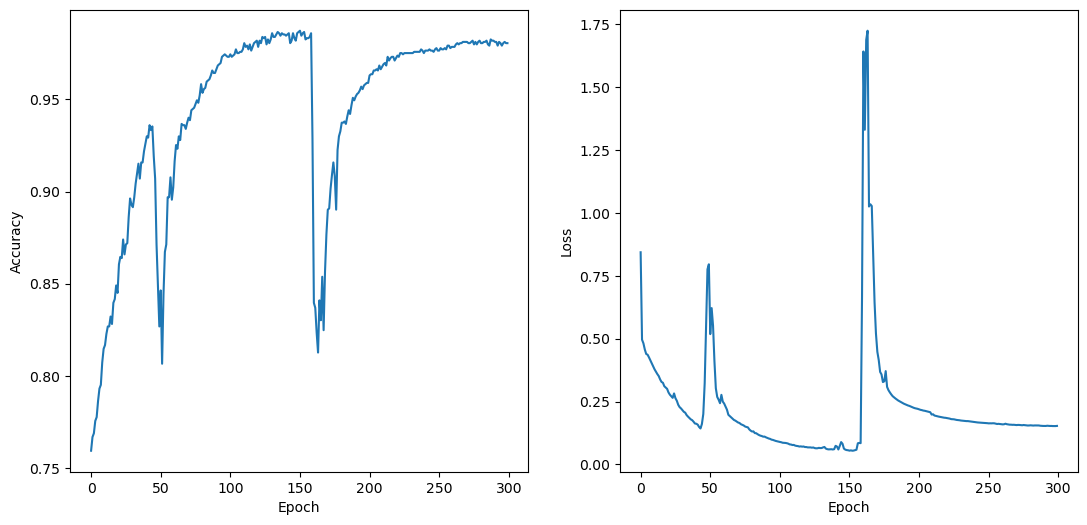

In [18]:
# Se muestran las gráficas de precisiónn y pérdida
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
ax1.plot(proceso.history['acc'])
ax1.set(xlabel= 'Epoch', ylabel='Accuracy');
ax2.plot((proceso.history['loss']))
ax2.set(xlabel= 'Epoch', ylabel='Loss');

In [19]:
# Se evalua el modelo
modelo.load_weights(filepath)
resultado  = modelo.evaluate(Xtest,  Ytest)
print("\nEl test loss obtenido ha sido:", resultado[0])
print("La precisión obtenida ha sido:", resultado[1])

636/636 [==============================] - 0s 214us/sample - loss: 2.5298 - acc: 0.7311

El test loss obtenido ha sido: 2.5298196744618924
La precisión obtenida ha sido: 0.7311321


In [20]:
# Se realizan predicciones
Ypredic= modelo.predict(Xtest)

# Se pasan las predicciones a 0s y 1s
Yprocesada = []
for y in Ypredic:
    if y <= 0.5:
        Yprocesada.append(0)
    else:
        Yprocesada.append(1)

In [21]:
# Se muestra la matriz de confusión
print("La matriz de confusion obtenida es:\n", confusion_matrix(Ytest, Yprocesada))

La matriz de confusion obtenida es:
 [[404  82]
 [ 89  61]]


### Sobremuestreo de los datos

In [22]:
# Se crea el ROS
#ros = RandomOverSampler()
sm = SMOTE()

In [23]:
# Se realiza un sobremuestreo de los datos
Xsm, Ysm = sm.fit_resample(nuevoX, Y)

In [24]:
# Se pasan los datos 2D a 3D para el modelo
Xsm = np.expand_dims(Xsm, axis=-1)
Xsm.shape

(3240, 208, 1)

In [25]:
# Se obtienen los datos para train y para test
Xtrainsm, Xtestsm, Ytrainsm, Ytestsm = train_test_split(Xsm, Ysm, test_size=0.3, random_state=18)

In [26]:
# Se crea y se muestra el modelo
modelo2 = Sequential();
modelo2.add(Conv1D(32, 3, activation='relu', input_shape=(maxLongitud, 1)))
modelo2.add(MaxPooling1D(2))
modelo2.add(Flatten())
modelo2.add(Dense(32, activation='relu'))
modelo2.add(Dense(8, activation='relu'))
modelo2.add(Dense(1, activation='relu'))

modelo2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 206, 32)           128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 103, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3296)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                105504    
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 105,905
Trainable params: 105,905
Non-trainable params: 0
________________________________________________

In [27]:
# Se compila el modelo
modelo2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
# Se entrena el modelo
proceso2 = modelo2.fit(Xtrainsm, Ytrainsm, epochs=300, batch_size=100)

Epoch 1/300
2268/2268 [==============================] - 1s 402us/sample - loss: 7.5765 - acc: 0.5088
Epoch 2/300
2268/2268 [==============================] - 0s 199us/sample - loss: 7.5765 - acc: 0.5088
Epoch 3/300
2268/2268 [==============================] - 0s 191us/sample - loss: 7.5765 - acc: 0.5088
Epoch 4/300
2268/2268 [==============================] - 0s 192us/sample - loss: 7.5765 - acc: 0.5088
Epoch 5/300
2268/2268 [==============================] - 0s 204us/sample - loss: 7.5765 - acc: 0.5088
Epoch 6/300
2268/2268 [==============================] - 0s 174us/sample - loss: 7.5765 - acc: 0.5088
Epoch 7/300
2268/2268 [==============================] - 0s 186us/sample - loss: 7.5765 - acc: 0.5088
Epoch 8/300
2268/2268 [==============================] - 0s 193us/sample - loss: 7.5765 - acc: 0.5088
Epoch 9/300
2268/2268 [==============================] - 0s 167us/sample - loss: 7.5765 - acc: 0.5088
Epoch 10/300
2268/2268 [==============================] - 0s 166us/sample - loss: 

2268/2268 [==============================] - 0s 210us/sample - loss: 7.5765 - acc: 0.5088
Epoch 160/300
2268/2268 [==============================] - 0s 190us/sample - loss: 7.5765 - acc: 0.5088
Epoch 161/300
2268/2268 [==============================] - 0s 184us/sample - loss: 7.5765 - acc: 0.5088
Epoch 162/300
2268/2268 [==============================] - 0s 167us/sample - loss: 7.5765 - acc: 0.5088
Epoch 163/300
2268/2268 [==============================] - 0s 160us/sample - loss: 7.5765 - acc: 0.5088
Epoch 164/300
2268/2268 [==============================] - 0s 159us/sample - loss: 7.5765 - acc: 0.5088
Epoch 165/300
2268/2268 [==============================] - 0s 161us/sample - loss: 7.5765 - acc: 0.5088
Epoch 166/300
2268/2268 [==============================] - 0s 154us/sample - loss: 7.5765 - acc: 0.5088
Epoch 167/300
2268/2268 [==============================] - 0s 171us/sample - loss: 7.5765 - acc: 0.5088
Epoch 168/300
2268/2268 [==============================] - 0s 183us/sample - l

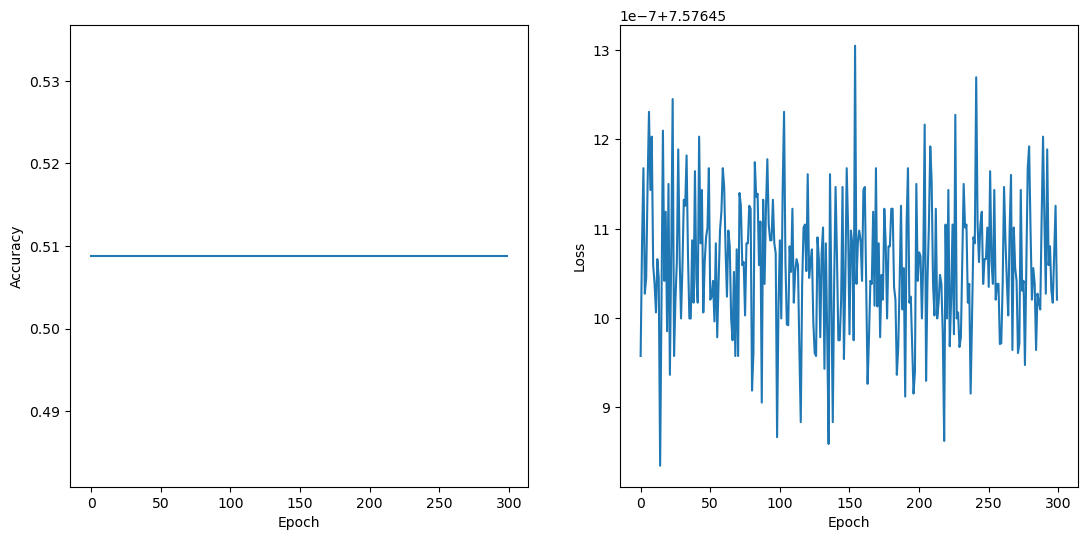

In [29]:
# Se muestran las gráficas de precisiónn y pérdida
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
ax1.plot(proceso2.history['acc'])
ax1.set(xlabel= 'Epoch', ylabel='Accuracy');
ax2.plot((proceso2.history['loss']))
ax2.set(xlabel= 'Epoch', ylabel='Loss');

In [30]:
# Se evalua el modelo
resultado  = modelo2.evaluate(Xtestsm,  Ytestsm)
print("\nEl test loss obtenido ha sido:", resultado[0])
print("La precisión obtenida ha sido:", resultado[1])

972/972 [==============================] - 0s 208us/sample - loss: 8.0299 - acc: 0.4794

El test loss obtenido ha sido: 8.029860096213259
La precisión obtenida ha sido: 0.47942388


In [31]:
# Se realizan predicciones
Ypredic= modelo.predict(Xtestsm)

# Se pasan las predicciones a 0s y 1s
Yprocesada = []
for y in Ypredic:
    if y <= 0.5:
        Yprocesada.append(0)
    else:
        Yprocesada.append(1)

In [32]:
# Se muestra la matriz de confusión
print("La matriz de confusion obtenida es:\n", confusion_matrix(Ytestsm, Yprocesada))

La matriz de confusion obtenida es:
 [[438  28]
 [179 327]]


### Aplicando Cross Validation

#### Datos originales

In [33]:
# Validación cruzada de 5 modelos
kfold = KFold(5)
# Se concatenan las features y lables destinadas pora train y test en el modelo anterior
features = np.concatenate((Xtrain, Xtest), axis=0)
labels = np.concatenate((Ytrain, Ytest), axis=0)
# Contador del número de modelo que se esta construyendo
kContador = 1
# Listas que contendrán los modelos generados junto con su historial
modelos = []
historial = []

# Se empieza la validación cruzada
for train, test in kfold.split(features, labels):
    # Se muestra el número de modelo y se construye
    print("\nModelo", kContador)
    modelo = Sequential();
    modelo.add(Conv1D(32, 3, activation='relu', input_shape=(maxLongitud, 1)))
    modelo.add(MaxPooling1D(2))
    modelo.add(Flatten())
    modelo.add(Dense(32, activation='relu'))
    modelo.add(Dense(8, activation='relu'))
    modelo.add(Dense(1, activation='relu'))
    
    # Se compila el modelo
    modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=0, save_best_only=True, mode='max')
    
    # Se entrena el modelo y se guarda el historial de entrenamiento y el modelo obtenido
    proceso = modelo.fit(features[train], labels[train], epochs=300, batch_size=100, verbose=0, callbacks=[checkpoint])
    historial.append(proceso)
    modelo.load_weights(filepath)
    modelos.append(modelo)
    
    # Se evalua el modelo y se muestran los datos
    resultado  = modelo.evaluate(features[test],  labels[test], verbose=0)
    print("\nEl test loss obtenido ha sido:", resultado[0])
    print("La precisión obtenida ha sido:", resultado[1])
    
    # Se incrementa en 1 el contador de modelos
    kContador+=1


Modelo 1

El test loss obtenido ha sido: 2.0485519316961183
La precisión obtenida ha sido: 0.7051887

Modelo 2

El test loss obtenido ha sido: 2.4496106831532605
La precisión obtenida ha sido: 0.7287736

Modelo 3

El test loss obtenido ha sido: 2.7789319056384967
La precisión obtenida ha sido: 0.7311321

Modelo 4

El test loss obtenido ha sido: 2.9478954346674793
La precisión obtenida ha sido: 0.7075472

Modelo 5

El test loss obtenido ha sido: 2.2634741191594108
La precisión obtenida ha sido: 0.759434


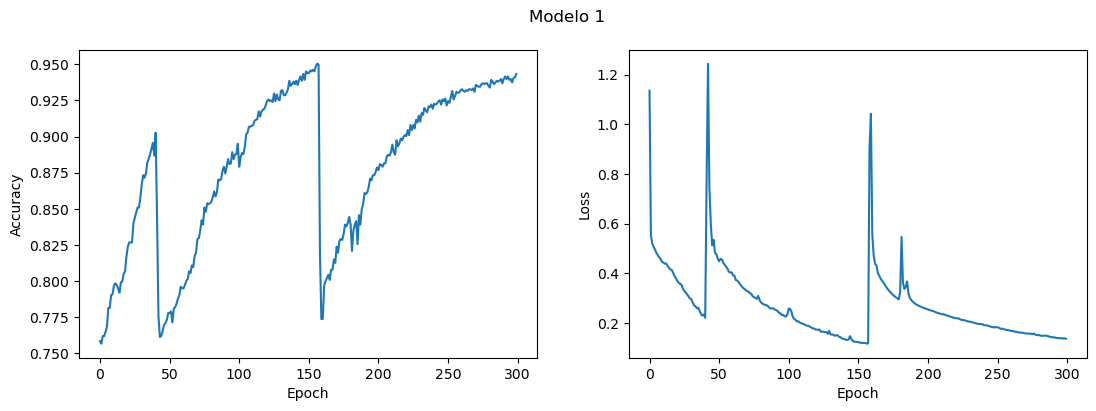

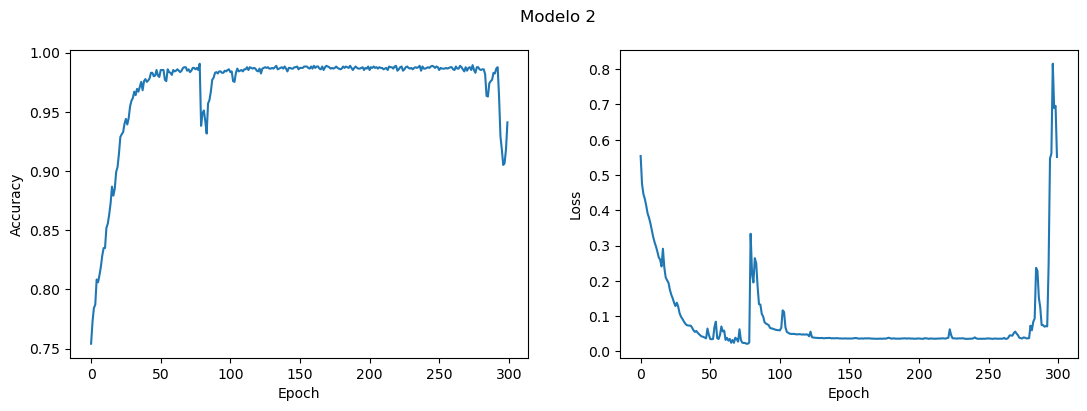

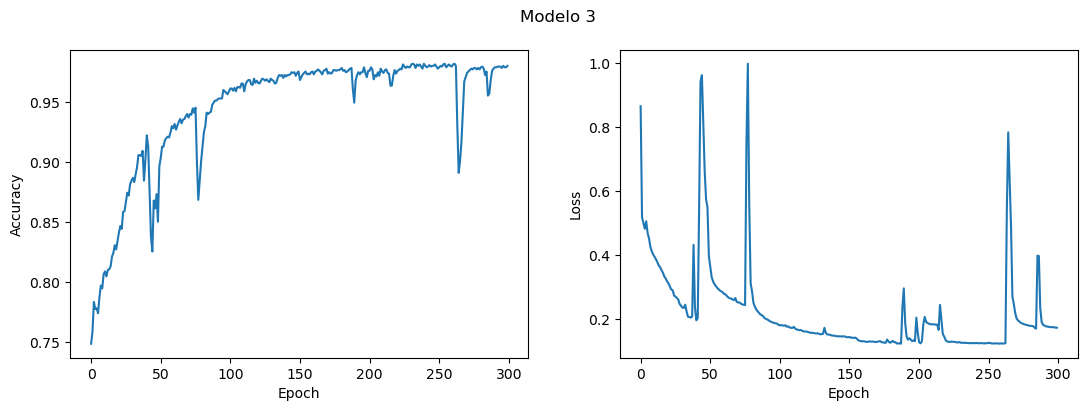

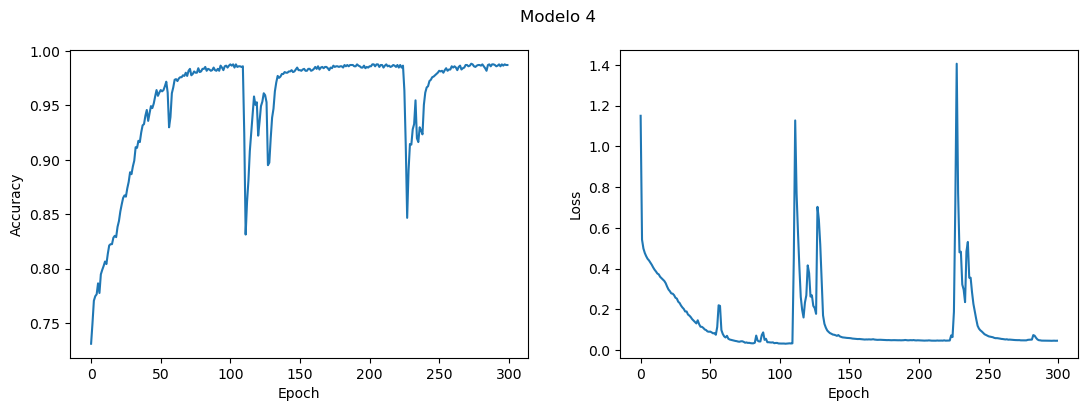

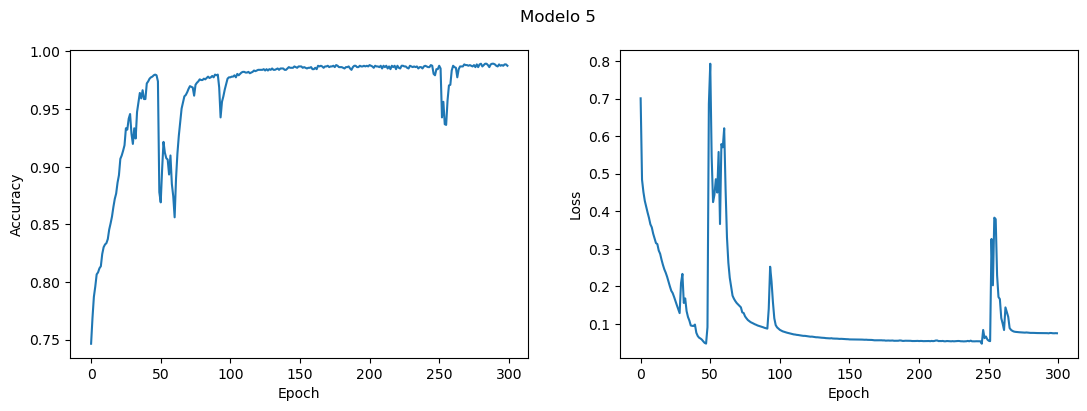

In [34]:
# Se muestran las gráficas de todos los modelos
for i in range(len(historial)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
    fig.suptitle("Modelo " + str(i+1))
    ax1.plot(historial[i].history['acc'])
    ax1.set(xlabel= 'Epoch', ylabel='Accuracy');
    ax2.plot((historial[i].history['loss']))
    ax2.set(xlabel= 'Epoch', ylabel='Loss');
    

#### Datos con sobremuestreo

In [35]:
# Validación cruzada de 5 modelos
kfold = KFold(5)
# Se concatenan las features y lables destinadas pora train y test en el modelo anterior
features = np.concatenate((Xtrainsm, Xtestsm), axis=0)
labels = np.concatenate((Ytrainsm, Ytestsm), axis=0)
# Contador del número de modelo que se esta construyendo
kContador = 1
# Listas que contendrán los modelos generados junto con su historial
modelos2 = []
historial2 = []

for train, test in kfold.split(features, labels):
    # Se muestra el número de modelo y se construye
    print("\nModelo", kContador)
    modelo = Sequential();
    modelo.add(Conv1D(32, 3, activation='relu', input_shape=(maxLongitud, 1)))
    modelo.add(MaxPooling1D(2))
    modelo.add(Flatten())
    modelo.add(Dense(32, activation='relu'))
    modelo.add(Dense(8, activation='relu'))
    modelo.add(Dense(1, activation='relu'))
    
    # Se compila el modelo
    modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])    
    checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=0, save_best_only=True, mode='max')
    # Se entrena el modelo y se guarda el histotial y el modelo
    proceso = modelo.fit(features[train], labels[train], epochs=300, batch_size=100, verbose=0, callbacks=[checkpoint])
    historial2.append(proceso)
    modelo.load_weights(filepath)
    modelos2.append(modelo)
    
    # Se evalua el modelo y se muestra
    resultado  = modelo.evaluate(features[test],  labels[test], verbose=0)
    print("\nEl test loss obtenido ha sido:", resultado[0])
    print("La precisión obtenida ha sido:", resultado[1])
    
    # Se incrementa en 1 el contador de modelos
    kContador+=1


Modelo 1

El test loss obtenido ha sido: 1.6539764904681546
La precisión obtenida ha sido: 0.81635803

Modelo 2

El test loss obtenido ha sido: 0.9451202385955386
La precisión obtenida ha sido: 0.7669753

Modelo 3

El test loss obtenido ha sido: 1.359333868379946
La precisión obtenida ha sido: 0.8132716

Modelo 4

El test loss obtenido ha sido: 2.3211940983195363
La precisión obtenida ha sido: 0.7839506

Modelo 5

El test loss obtenido ha sido: 2.3046591377552645
La precisión obtenida ha sido: 0.78549385


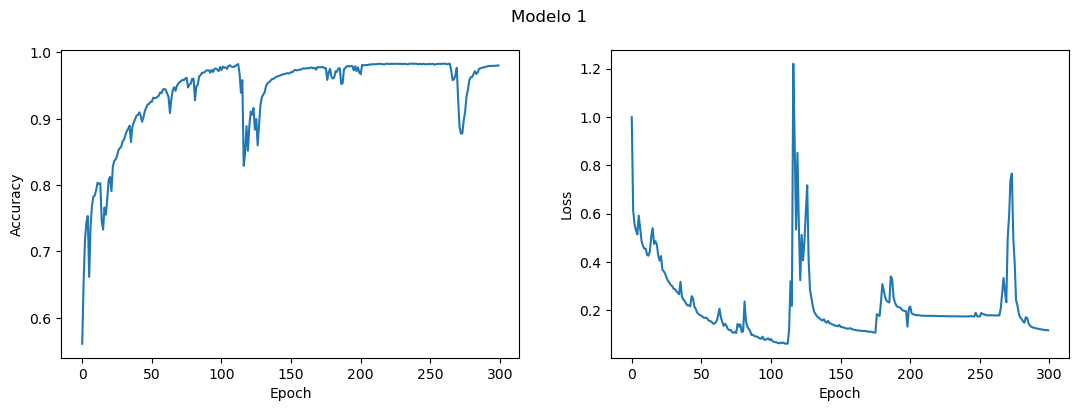

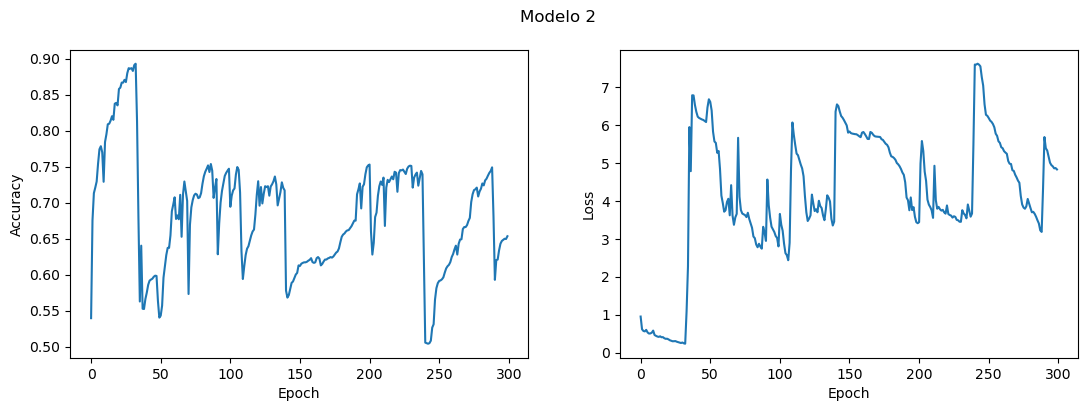

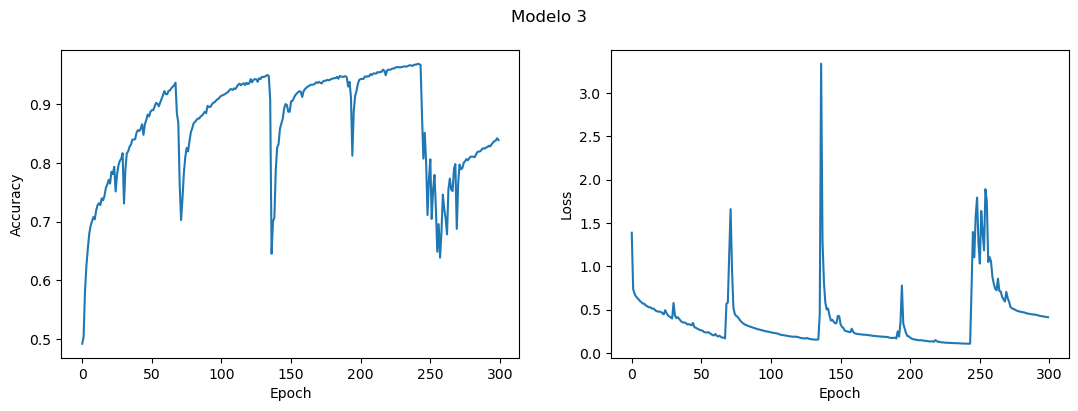

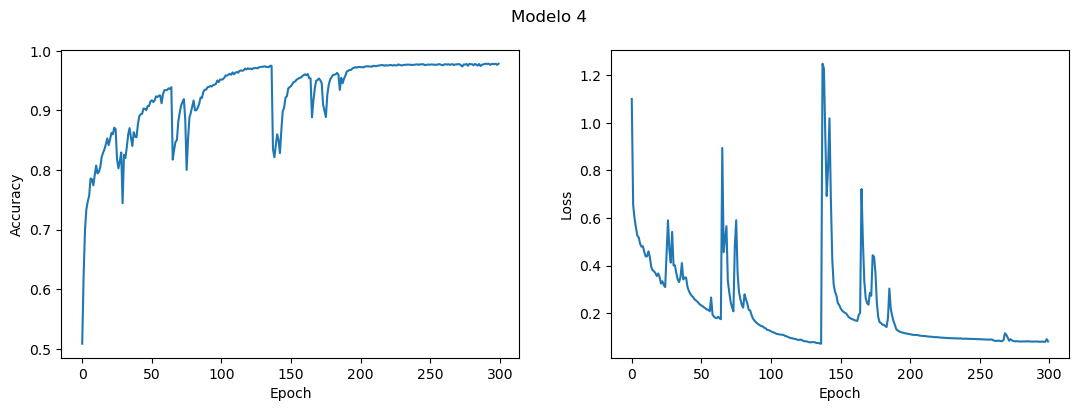

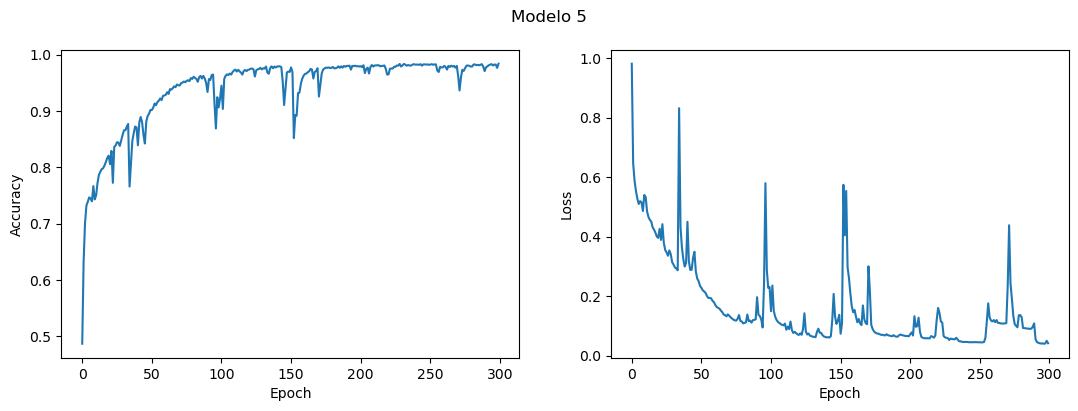

In [36]:
# Se muestran las gráficas de todos los modelos obtenidos
for i in range(len(historial2)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
    fig.suptitle("Modelo " + str(i+1))
    ax1.plot(historial2[i].history['acc'])
    ax1.set(xlabel= 'Epoch', ylabel='Accuracy');
    ax2.plot((historial2[i].history['loss']))
    ax2.set(xlabel= 'Epoch', ylabel='Loss');

### Guardar todos los modelos

In [37]:
# Se crean los directorios donde se van a guardar los modelos
os.makedirs('cnn/original', exist_ok=True)
os.makedirs('cnn/sobremuestreo', exist_ok=True)

In [38]:
# Se guarda el modelo obtenido con validación cruzada con datos originales
for i in range(len(modelos)):
    modelos[i].save('cnn/original/modelo' + str(i+1))
# Se guarda el modelo obtenido con validación cruzada aplicando sobremuestreo en los datos    
for i in range(len(modelos2)):
    modelos2[i].save('cnn/sobremuestreo/modelo' + str(i+1))

### Evaluación de los modelos con las muestras

In [39]:
# Se preparán los datos de la muestra para usarse en modelos
muesProceX = []
for x in muestraX:
    muesProceX.append(np.pad(x, (0,maxLongitud-len(x)), 'constant', constant_values= 0))
        
muesProceX = np.expand_dims(muesProceX, axis=-1)

muesProceY = []
for y in muestraY:
    if y == 'OK':
        muesProceY.append(0)
    else:
        muesProceY.append(1) 


#### Modelos con datos originales

In [40]:
# Se crea un array de las predicciones
predicciones = np.zeros(len(muesProceY))

# Se recorren todos los modelos generados y se realizan las predicciones
for m in modelos:
    Yprocesada = []
    # Se ajustan las predicciones según el criterio de menor o igual a 0.5 es 0 y sino es 1
    for y in m.predict(muesProceX):
        if y <= 0.5:
            Yprocesada.append(0)
        else:
            Yprocesada.append(1)
    # Se suman los valores con las predicciones de otros modelos
    predicciones = np.sum([predicciones, Yprocesada], axis=0)

# Se divide entre 5 el valor de las predicciones (ya que se han usado 5 modelo)
predicciones = predicciones/5

In [41]:
# Se ajustan las predicciones según el criterio
Yprocesada = []
for y in predicciones:
    if y <= 0.5:
        Yprocesada.append(0)
    else:
        Yprocesada.append(1)

In [42]:
# Se muestra la matriz de confusión
print("La matriz de confusion obtenida es:\n", confusion_matrix(muesProceY, Yprocesada))

La matriz de confusion obtenida es:
 [[ 44   6]
 [114  36]]


### Modelos con sobremuestreo

In [43]:
predicciones = np.zeros(len(muesProceY))

for m in modelos2:
    Yprocesada = []
    for y in m.predict(muesProceX):
        if y <= 0.5:
            Yprocesada.append(0)
        else:
            Yprocesada.append(1)
    predicciones = np.sum([predicciones, Yprocesada], axis=0)

predicciones = predicciones/5

In [44]:
Yprocesada = []
for y in predicciones:
    if y <= 0.5:
        Yprocesada.append(0)
    else:
        Yprocesada.append(1)

In [45]:
# Se muestra la matriz de confusión
print("La matriz de confusion obtenida es:\n", confusion_matrix(muesProceY, Yprocesada))

La matriz de confusion obtenida es:
 [[40 10]
 [94 56]]


### Modelos con nuevos parámetros

#### Kernel_size = 5

In [51]:
# Validación cruzada de 5 modelos
kfold = KFold(5)
# Se concatenan las features y lables destinadas pora train y test en el modelo anterior
features = np.concatenate((Xtrainsm, Xtestsm), axis=0)
labels = np.concatenate((Ytrainsm, Ytestsm), axis=0)
# Contador del número de modelo que se esta construyendo
kContador = 1
# Listas que contendrán los modelos generados junto con su historial
modelos2 = []
historial2 = []

for train, test in kfold.split(features, labels):
    # Se muestra el número de modelo y se construye
    print("\nModelo", kContador)
    modelo = Sequential();
    modelo.add(Conv1D(32, 5, activation='relu', input_shape=(maxLongitud, 1)))
    modelo.add(MaxPooling1D(2))
    modelo.add(Flatten())
    modelo.add(Dense(32, activation='relu'))
    modelo.add(Dense(8, activation='relu'))
    modelo.add(Dense(1, activation='relu'))
    
    # Se compila el modelo
    modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])    
    checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=0, save_best_only=True, mode='max')
    # Se entrena el modelo y se guarda el histotial y el modelo
    proceso = modelo.fit(features[train], labels[train], epochs=300, batch_size=100, verbose=0, callbacks=[checkpoint])
    historial2.append(proceso)
    modelo.load_weights(filepath)
    modelos2.append(modelo)
    
    # Se evalua el modelo y se muestra
    resultado  = modelo.evaluate(features[test],  labels[test], verbose=0)
    print("\nEl test loss obtenido ha sido:", resultado[0])
    print("La precisión obtenida ha sido:", resultado[1])
    
    # Se incrementa en 1 el contador de modelos
    kContador+=1


Modelo 1

El test loss obtenido ha sido: 1.7080939419475603
La precisión obtenida ha sido: 0.7993827

Modelo 2

El test loss obtenido ha sido: 1.7533807195263145
La precisión obtenida ha sido: 0.7916667

Modelo 3

El test loss obtenido ha sido: 1.6148225378107142
La precisión obtenida ha sido: 0.8055556

Modelo 4

El test loss obtenido ha sido: 2.0300003363762373
La precisión obtenida ha sido: 0.7808642

Modelo 5

El test loss obtenido ha sido: 1.9096155012095417
La precisión obtenida ha sido: 0.79320985


In [52]:
predicciones = np.zeros(len(muesProceY))

for m in modelos2:
    Yprocesada = []
    for y in m.predict(muesProceX):
        if y <= 0.5:
            Yprocesada.append(0)
        else:
            Yprocesada.append(1)
    predicciones = np.sum([predicciones, Yprocesada], axis=0)

predicciones = predicciones/5

Yprocesada = []
for y in predicciones:
    if y <= 0.5:
        Yprocesada.append(0)
    else:
        Yprocesada.append(1)
        
# Se muestra la matriz de confusión
print("La matriz de confusion obtenida es:\n", confusion_matrix(muesProceY, Yprocesada))

La matriz de confusion obtenida es:
 [[ 38  12]
 [101  49]]


#### Filters = 16 y kernel_size = 5

In [53]:
# Validación cruzada de 5 modelos
kfold = KFold(5)
# Se concatenan las features y lables destinadas pora train y test en el modelo anterior
features = np.concatenate((Xtrainsm, Xtestsm), axis=0)
labels = np.concatenate((Ytrainsm, Ytestsm), axis=0)
# Contador del número de modelo que se esta construyendo
kContador = 1
# Listas que contendrán los modelos generados junto con su historial
modelos2 = []
historial2 = []

for train, test in kfold.split(features, labels):
    # Se muestra el número de modelo y se construye
    print("\nModelo", kContador)
    modelo = Sequential();
    modelo.add(Conv1D(16, 5, activation='relu', input_shape=(maxLongitud, 1)))
    modelo.add(MaxPooling1D(2))
    modelo.add(Flatten())
    modelo.add(Dense(32, activation='relu'))
    modelo.add(Dense(8, activation='relu'))
    modelo.add(Dense(1, activation='relu'))
    
    # Se compila el modelo
    modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])    
    checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=0, save_best_only=True, mode='max')
    # Se entrena el modelo y se guarda el histotial y el modelo
    proceso = modelo.fit(features[train], labels[train], epochs=300, batch_size=100, verbose=0, callbacks=[checkpoint])
    historial2.append(proceso)
    modelo.load_weights(filepath)
    modelos2.append(modelo)
    
    # Se evalua el modelo y se muestra
    resultado  = modelo.evaluate(features[test],  labels[test], verbose=0)
    print("\nEl test loss obtenido ha sido:", resultado[0])
    print("La precisión obtenida ha sido:", resultado[1])
    
    # Se incrementa en 1 el contador de modelos
    kContador+=1


Modelo 1

El test loss obtenido ha sido: 7.379219243555893
La precisión obtenida ha sido: 0.52160496

Modelo 2

El test loss obtenido ha sido: 2.0210216339723566
La precisión obtenida ha sido: 0.78858024

Modelo 3

El test loss obtenido ha sido: 1.4544634627707211
La precisión obtenida ha sido: 0.8240741

Modelo 4

El test loss obtenido ha sido: 1.8649178095805792
La precisión obtenida ha sido: 0.8055556

Modelo 5

El test loss obtenido ha sido: 2.3869690306392717
La precisión obtenida ha sido: 0.7685185


In [54]:
predicciones = np.zeros(len(muesProceY))

for m in modelos2:
    Yprocesada = []
    for y in m.predict(muesProceX):
        if y <= 0.5:
            Yprocesada.append(0)
        else:
            Yprocesada.append(1)
    predicciones = np.sum([predicciones, Yprocesada], axis=0)

predicciones = predicciones/5

Yprocesada = []
for y in predicciones:
    if y <= 0.5:
        Yprocesada.append(0)
    else:
        Yprocesada.append(1)
        
# Se muestra la matriz de confusión
print("La matriz de confusion obtenida es:\n", confusion_matrix(muesProceY, Yprocesada))

La matriz de confusion obtenida es:
 [[ 39  11]
 [106  44]]


#### Filters = 64 y kernel_size = 3

In [49]:
# Validación cruzada de 5 modelos
kfold = KFold(5)
# Se concatenan las features y lables destinadas pora train y test en el modelo anterior
features = np.concatenate((Xtrainsm, Xtestsm), axis=0)
labels = np.concatenate((Ytrainsm, Ytestsm), axis=0)
# Contador del número de modelo que se esta construyendo
kContador = 1
# Listas que contendrán los modelos generados junto con su historial
modelos2 = []
historial2 = []

for train, test in kfold.split(features, labels):
    # Se muestra el número de modelo y se construye
    print("\nModelo", kContador)
    modelo = Sequential();
    modelo.add(Conv1D(64, 3, activation='relu', input_shape=(maxLongitud, 1)))
    modelo.add(MaxPooling1D(2))
    modelo.add(Flatten())
    modelo.add(Dense(32, activation='relu'))
    modelo.add(Dense(8, activation='relu'))
    modelo.add(Dense(1, activation='relu'))
    
    # Se compila el modelo
    modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])    
    checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=0, save_best_only=True, mode='max')
    # Se entrena el modelo y se guarda el histotial y el modelo
    proceso = modelo.fit(features[train], labels[train], epochs=300, batch_size=100, verbose=0, callbacks=[checkpoint])
    historial2.append(proceso)
    modelo.load_weights(filepath)
    modelos2.append(modelo)
    
    # Se evalua el modelo y se muestra
    resultado  = modelo.evaluate(features[test],  labels[test], verbose=0)
    print("\nEl test loss obtenido ha sido:", resultado[0])
    print("La precisión obtenida ha sido:", resultado[1])
    
    # Se incrementa en 1 el contador de modelos
    kContador+=1


Modelo 1

El test loss obtenido ha sido: 1.856226325770955
La precisión obtenida ha sido: 0.80246913

Modelo 2

El test loss obtenido ha sido: 2.039752671748032
La precisión obtenida ha sido: 0.79320985

Modelo 3

El test loss obtenido ha sido: 1.6765942661850541
La precisión obtenida ha sido: 0.8132716

Modelo 4

El test loss obtenido ha sido: 2.4440662066141763
La precisión obtenida ha sido: 0.7947531

Modelo 5

El test loss obtenido ha sido: 2.201947131274659
La precisión obtenida ha sido: 0.77469134


In [50]:
predicciones = np.zeros(len(muesProceY))

for m in modelos2:
    Yprocesada = []
    for y in m.predict(muesProceX):
        if y <= 0.5:
            Yprocesada.append(0)
        else:
            Yprocesada.append(1)
    predicciones = np.sum([predicciones, Yprocesada], axis=0)

predicciones = predicciones/5

Yprocesada = []
for y in predicciones:
    if y <= 0.5:
        Yprocesada.append(0)
    else:
        Yprocesada.append(1)
        
# Se muestra la matriz de confusión
print("La matriz de confusion obtenida es:\n", confusion_matrix(muesProceY, Yprocesada))

La matriz de confusion obtenida es:
 [[37 13]
 [96 54]]
